In [46]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

In [47]:
# Download NLTK data
nltk.data.path.append('data/nltk_data')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/whats2000/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/whats2000/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/whats2000/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available, using CPU.")

GPUs available: 1


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1. Data Read and Basic Check</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Yelp Data Structure</div>

### Overview

The dataset contains reviews from Yelp, including business information, dates, reviews, ratings, and text.

---

### Raw Data Structure (`yelp.csv`)

Main fields (checked from the data file):

- `business_id`: Business ID, string
- `date`: Review date, string or date format
- `review_id`: Review ID, string
- `stars`: Rating (integer, usually 1–5)
- `text`: Review content (mainly English text)
- `type`: Record type (e.g., "review")
- `user_id`: User ID
- `cool`: Number of times the review was marked as cool (integer)
- `useful`: Number of times marked as useful (integer)
- `funny`: Number of times marked as funny (integer)

This task **will only use**:

- `text`: As input feature (X)
- `stars`: Converted to binary label (y)

### Label Conversion Rules

- If `stars >= 4` → Label as `1` (positive)
- If `stars < 4` → Label as `0` (negative)

### Data Split Rules

- Read the full `yelp.csv`
- Keep only `text`, `stars`
- Generate new field according to label conversion (e.g., `label`)
- Split data into **80% / 20%** ratio:
  - `train_df` (training set)
  - `test_df` (test set)
- When splitting, consider **stratify** (stratified sampling by label proportion), so that positive/negative ratios are similar in train/test

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the data and display head</div>

In [49]:
# Load the Yelp review data
yelp_file_path = os.path.join('data', 'yelp.csv')
df_raw = pd.read_csv(yelp_file_path)

# Displaying the first few rows
print("First few rows of the dataset:")
display(df_raw.head())

# Data shape
print(f"\nData shape: {df_raw.shape}")

# Column names and types
print(f"\nColumn names and types:\n{df_raw.dtypes}")

# Check for null values
print(f"\nNull value counts:\n{df_raw.isna().sum()}")

First few rows of the dataset:


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0



Data shape: (10000, 10)

Column names and types:
business_id    object
date           object
review_id      object
stars           int64
text           object
type           object
user_id        object
cool            int64
useful          int64
funny           int64
dtype: object

Null value counts:
business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">See the statistical summary of the dataset</div>

In [50]:
# Statistical summary of the dataset
df_raw.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2. Data Preprocessing and Label Creation (train / test split)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Keep necessary columns and create binary labels</div>

In [51]:
# Keep only 'text' and 'stars' columns
df = df_raw[['text', 'stars']].copy()

# Create binary labels
df['label'] = (df['stars'] >= 4).astype(int)

# Check label distribution
print("Label distribution:")
print(df['label'].value_counts(normalize=True))

Label distribution:
label
1    0.6863
0    0.3137
Name: proportion, dtype: float64


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Split data into train and test</div>

In [52]:
# Split into features and labels
X = df['text']
y = df['label']

# Train/test split: 80% train, 20% test, stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Train labels distribution: {y_train.value_counts(normalize=True)}")
print(f"Test labels distribution: {y_test.value_counts(normalize=True)}")

Train set size: 8000
Test set size: 2000
Train labels distribution: label
1    0.68625
0    0.31375
Name: proportion, dtype: float64
Test labels distribution: label
1    0.6865
0    0.3135
Name: proportion, dtype: float64


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3. Text Cleaning and Stop Words Processing</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Clean the text data</div>

In [53]:
# Prepare stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    # Split into tokens
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Join back
    return ' '.join(tokens)

# Clean train and test texts
X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

# Check a few examples
print("Original text example:")
print(X_train.iloc[0])
print("\nCleaned text example:")
print(X_train_clean.iloc[0])

Original text example:
Yumm yumm yumm!   The burgers are fantastic and yummy!

The service has always been top notch, fast and freindly.
Love the inside and outside environment.    Could do without the TVs with sports playing on them...don't we get enough plugged in entertainment in our lives already?....but I'm probably in the minority.

Kid friendly for those well behaved kids of course. :)

Cleaned text example:
yumm yumm yumm burgers fantastic yummy service always top notch fast freindly love inside outside environment could without tvs sports playing themdont get enough plugged entertainment lives alreadybut im probably minority kid friendly well behaved kids course


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4. Text to Vectors (Tokenizer + Embedding)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Tokenize and pad sequences</div>

In [54]:
# Set hyperparameters
max_words = 20000
max_len = 200

# Tokenize
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_clean)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Embedding settings
input_dim = min(max_words, len(tokenizer.word_index) + 1)
output_dim = 128

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Input dim for Embedding: {input_dim}")
print(f"X_train_pad shape: {X_train_pad.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}")

Vocabulary size: 32276
Input dim for Embedding: 20000
X_train_pad shape: (8000, 200)
X_test_pad shape: (2000, 200)


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5. Build and Train CNN Models (with/without Dropout)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Build CNN models</div>

In [55]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def build_cnn_model(dropout_rate=None):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_len))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build models
cnn_baseline = build_cnn_model()
cnn_dropout = build_cnn_model(0.7)

/mnt/d/GitHub/Yelp-Food-Review-Sentiment-Analysis/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Train CNN models</div>

In [56]:
# Training parameters
epochs = 8
batch_size = 64

# Train baseline CNN
print("Training CNN baseline...")
history_cnn_base = cnn_baseline.fit(
    X_train_pad, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.1, 
    verbose=1
)

# Train CNN with Dropout
print("\nTraining CNN with Dropout...")
history_cnn_dropout = cnn_dropout.fit(
    X_train_pad, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.1, 
    verbose=1
)

Training CNN baseline...
Epoch 1/8


2025-11-24 01:17:46.121102: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-24 01:17:46.121168: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-24 01:17:46.121178: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-24 01:17:46.121186: I external/l

113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6836 - loss: 0.6001 - val_accuracy: 0.7063 - val_loss: 0.5405
Epoch 2/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6836 - loss: 0.6001 - val_accuracy: 0.7063 - val_loss: 0.5405
Epoch 2/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7974 - loss: 0.4180 - val_accuracy: 0.8012 - val_loss: 0.4657
Epoch 3/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7974 - loss: 0.4180 - val_accuracy: 0.8012 - val_loss: 0.4657
Epoch 3/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9174 - loss: 0.2032 - val_accuracy: 0.7962 - val_loss: 0.5981
Epoch 4/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9174 - loss: 0.2032 - val_accuracy: 0.7962 - val_loss: 0.5981
Epoch 4/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9513 - loss: 0.1162 - val_accuracy: 0.7625 - val_loss: 0.7547
Epoch 5/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9513 - loss: 0.1162 - val_accuracy: 0.7625 - val_los

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6. Build and Train LSTM Models (with/without Dropout)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Build LSTM models</div>

In [ ]:
def build_lstm_model(dropout_rate=None):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_len))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(LSTM(256, return_sequences=True))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build models
lstm_baseline = build_lstm_model()
lstm_dropout = build_lstm_model(0.7)


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Train LSTM models</div>

In [58]:
# Train baseline LSTM
print("Training LSTM baseline...")
history_lstm_base = lstm_baseline.fit(
    X_train_pad, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.1, 
    verbose=1
)

# Train LSTM with Dropout
print("\nTraining LSTM with Dropout...")
history_lstm_dropout = lstm_dropout.fit(
    X_train_pad, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.1, 
    verbose=1
)

Training LSTM baseline...
Epoch 1/8
Epoch 1/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6821 - loss: 0.6149 - val_accuracy: 0.6988 - val_loss: 0.5896
Epoch 2/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6821 - loss: 0.6149 - val_accuracy: 0.6988 - val_loss: 0.5896
Epoch 2/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8112 - loss: 0.4198 - val_accuracy: 0.8025 - val_loss: 0.4162
Epoch 3/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8112 - loss: 0.4198 - val_accuracy: 0.8025 - val_loss: 0.4162
Epoch 3/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9131 - loss: 0.2397 - val_accuracy: 0.8062 - val_loss: 0.5439
Epoch 4/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9131 - loss: 0.2397 - val_accuracy: 0.8062 - val_loss: 0.5439
Epoch 4/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9451 - loss: 0.1551 - val_accuracy: 0.8188 - val_loss: 0.5810
Epoch 5/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.94

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7. Training Process Accuracy / Loss Visualization</div>

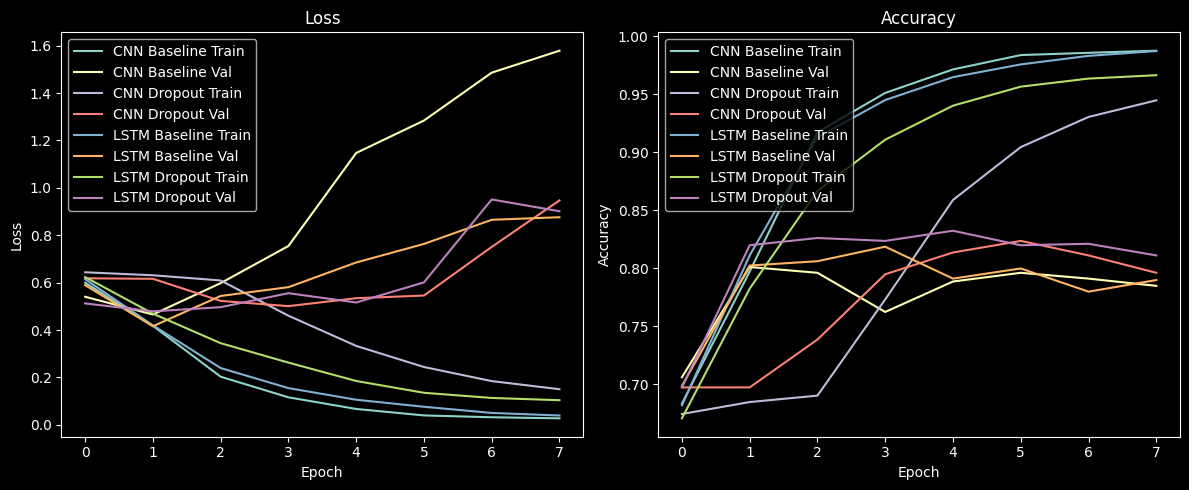

In [59]:
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_base.history['loss'], label='CNN Baseline Train')
plt.plot(history_cnn_base.history['val_loss'], label='CNN Baseline Val')
plt.plot(history_cnn_dropout.history['loss'], label='CNN Dropout Train')
plt.plot(history_cnn_dropout.history['val_loss'], label='CNN Dropout Val')
plt.plot(history_lstm_base.history['loss'], label='LSTM Baseline Train')
plt.plot(history_lstm_base.history['val_loss'], label='LSTM Baseline Val')
plt.plot(history_lstm_dropout.history['loss'], label='LSTM Dropout Train')
plt.plot(history_lstm_dropout.history['val_loss'], label='LSTM Dropout Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn_base.history['accuracy'], label='CNN Baseline Train')
plt.plot(history_cnn_base.history['val_accuracy'], label='CNN Baseline Val')
plt.plot(history_cnn_dropout.history['accuracy'], label='CNN Dropout Train')
plt.plot(history_cnn_dropout.history['val_accuracy'], label='CNN Dropout Val')
plt.plot(history_lstm_base.history['accuracy'], label='LSTM Baseline Train')
plt.plot(history_lstm_base.history['val_accuracy'], label='LSTM Baseline Val')
plt.plot(history_lstm_dropout.history['accuracy'], label='LSTM Dropout Train')
plt.plot(history_lstm_dropout.history['val_accuracy'], label='LSTM Dropout Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 8. Model Evaluation and Accuracy Calculation</div>

In [60]:
# Evaluate models on test set
models = {
    'CNN Baseline': cnn_baseline,
    'CNN Dropout': cnn_dropout,
    'LSTM Baseline': lstm_baseline,
    'LSTM Dropout': lstm_dropout
}

results = {}
for name, model in models.items():
    loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
    results[name] = acc
    print(f"{name}: Test Accuracy = {acc:.4f}")

# Display results table
import pandas as pd
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Test Accuracy'])
results_df

CNN Baseline: Test Accuracy = 0.7810
CNN Dropout: Test Accuracy = 0.7855
CNN Dropout: Test Accuracy = 0.7855
LSTM Baseline: Test Accuracy = 0.7715
LSTM Baseline: Test Accuracy = 0.7715
LSTM Dropout: Test Accuracy = 0.8055
LSTM Dropout: Test Accuracy = 0.8055


,Model,Test Accuracy
0,CNN Baseline,0.7810
1,CNN Dropout,0.7855
2,LSTM Baseline,0.7715
3,LSTM Dropout,0.8055
